In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Stable Diffusion

In [ ]:
device = torch.device("cuda:1")
torch.cuda.set_device(1) # For multiple GPUs
    
model = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
model.to(device);

## Load Image

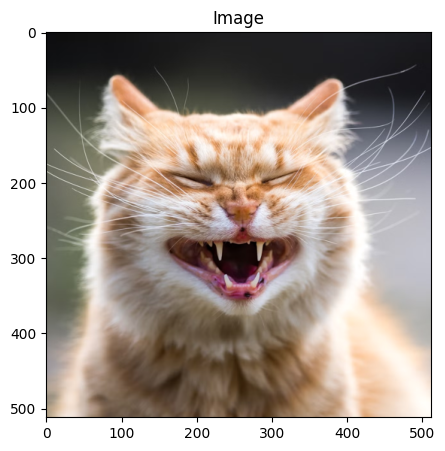

In [3]:
img_path = "../assets/thecat.jpg"

img = np.asarray(Image.open(img_path).resize((512,512)))[:,:,:3]
img = torch.from_numpy(img.copy())
img = (img.permute([2,0,1]) / 125.7 - 1).unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax.set_title("Image")
plt.show()

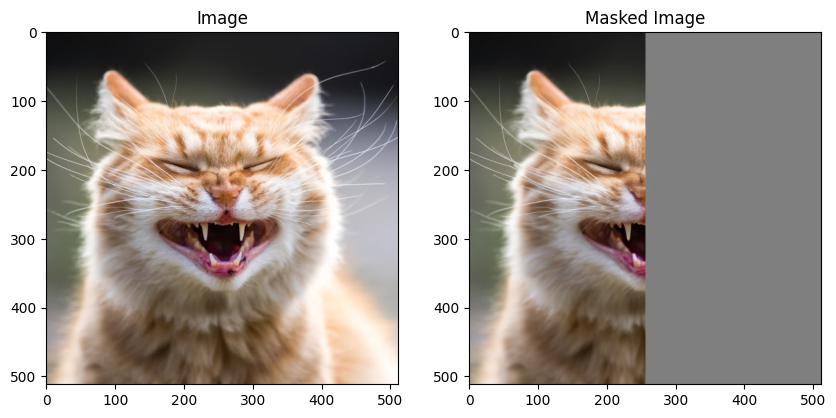

In [4]:
# Create pixel mask
mask = torch.zeros((1,3,512,512), device=device)
mask[:,:,:,:256] = 1

# Create latent mask
latent_mask = torch.ones((1,3,64,64), device=device)
latent_mask[F.avg_pool2d(mask, 8, 8, 0) < 1] = 0
latent_mask = torch.cat((latent_mask, latent_mask[:,[0],:,:]), dim=1)

# Encode masked image
with torch.no_grad():
    constraint = model.vae.encode(img*mask).latent_dist.mean * model.vae.config.scaling_factor
    constraint_img = model.vae.decode(constraint / model.vae.config.scaling_factor).sample

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[0].set_title("Image")
ax[1].imshow((0.5*(constraint_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[1].set_title("Masked Image")
plt.show()

## Inference

In [18]:
# Model forward pass
def model_pred(model, x, t, cond, uncond, w=1.0):
    with torch.no_grad():
        if w > 1.0:
            model_output = model.unet(torch.cat((x, x), dim=0),
                                    t, torch.cat((cond, uncond), dim=0)).sample
            bs = model_output.shape[0]//2
            eps_cond, eps_uncond = model_output[:bs,...], model_output[bs:,...]
            eps = (w+1)*eps_cond - w*eps_uncond
        else:
            eps = model.unet(x, t, cond).sample

    return eps


# Diffusion parameters
t = 1000
xt = torch.randn((1,4,64,64), device=device)
num_inference_steps = 20
model.scheduler.set_timesteps(num_inference_steps)

# Inference parameters
n_steps = 5
lr = np.linspace(0.5, 0.1, n_steps) # Linearly decreasing
h = 0.005
guidance_weight = 0.0

# Text caption
caption = ''
with torch.no_grad():
    cond, uncond = model.encode_prompt([caption], device=device,
                                       num_images_per_prompt=1,
                                       do_classifier_free_guidance=True)


# Run inference
for t in tqdm(model.scheduler.timesteps):
    tt = (t.item() + (1000//num_inference_steps-1)) # Diffusers starts t from 1000-stride
    atbar = model.scheduler.alphas_cumprod[tt-1] # model.scheduler.alphas_cumprod[t-1] also works

    # Compute x_0(x_t, t)
    epsilon = model_pred(model, xt, t, cond, uncond, guidance_weight)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

    for k in range(n_steps):
        # Comptue e
        error_dir = latent_mask*(constraint - x0_pred)

        # Compute x_0(x_t + h*e, t)
        h_adaptive = h / error_dir.abs().max()
        xt_error_dir = xt + h_adaptive*error_dir
        epsilon_error_dir = model_pred(model, xt_error_dir, t, cond, uncond, guidance_weight)
        x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)
        
        # Compute finite differences
        grad = (x0_pred_error_dir - x0_pred) / h_adaptive
        grad = grad / grad.abs().max()

        # Apply update
        xt = xt + lr[k]*grad

        # Recompute x_0(x_t, t)
        epsilon = model_pred(model, xt, t, cond, uncond, guidance_weight)
        x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)


    # Denoiser step x_t -> x_t-1
    xt = model.scheduler.step(epsilon, t, xt).prev_sample


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


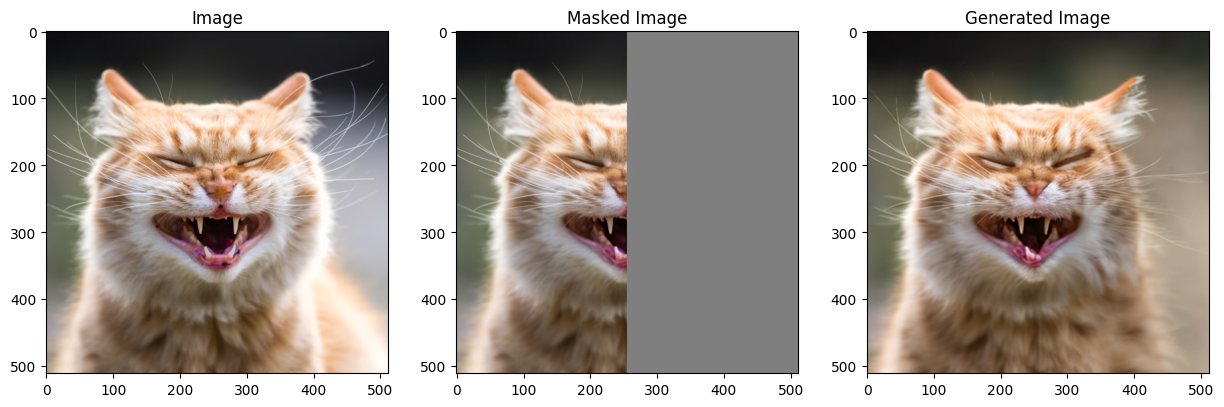

In [19]:
# Visualize result
with torch.no_grad():
    pred_img = model.vae.decode(xt / model.vae.config.scaling_factor).sample

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[0].set_title("Image")
ax[1].imshow((0.5*(constraint_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[1].set_title("Masked Image")
ax[2].imshow((0.5*(pred_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[2].set_title("Generated Image")
plt.show()